### Lecture 1: Low level descriptors

In this example, you will be implementing some of the low level feature extraction functions and applying those in analysis of a tiny dataset. 

Your contribution is expected in implementing parts of functions in the second cell. Please do not modify other parts of the code. We will go through it quickly in the lecture.

Your parts are marked with labels: #Your code starts here ... #Your code ends here

------
To form a larger dataset for this example, use the FreeSound example: https://github.com/MTG/MIRCourse/blob/master/notebooks/DownloadDataFromFreeSound_noToken.ipynb with query strings:'kiss' and 'whistle', setting a larger value for maxNumFilePerInst. The tiny set was created by setting maxNumFilePerInst=10 and further manually removing files which contained other sounds than 'kiss' or 'whistle'

The variable names: <instrumentX> is misleading in this example with the queries 'kiss' and 'whistle', but in the homework, you are expected to apply the same code on instrument sounds. Then naming will make sense. For this example, you can assume there are two categories of instruments 'kiss' and 'whistle', with which one can create different examples of kiss and whistle sounds. 

In [1]:
import os
import sys
import numpy as np
from scipy.fftpack import fft
from scipy.signal import get_window
import matplotlib.pyplot as plt
import essentia.standard as ess

%matplotlib inline

#---Functions already implemented (do not modify contents of this cell) ---

#Container for analysis parameters
class AnalysisParams:
    def __init__(self,windowSize,hopSize,windowFunction,fftN,fs):
        '''
        windowSize: milliseconds,
        hopSize: milliseconds,
        windowFunction: str ('blackman','hanning',...)
        fftN: int
        '''
        self.windowSize = windowSize
        self.hopSize = hopSize
        self.windowFunction = windowFunction
        self.fftN=fftN
        self.fs=fs

def initiateData4File(file,root):
    '''Forming the data structure for file
    Parameters
    ----------
    file,root : str
        File name and path info
    
    Returns
    -------
    fileData : dict
        Dictionary containing all info and data for the file
    ''' 
    fileData=dict();fileData['name']=file;fileData['path']=root;
    #Low level(LL) features
    fileData['NRG']=[];fileData['zcr']=[];#time domain features
    fileData['specCentroid']=[];fileData['specFlatness']=[];#frequency domain features
    
    return fileData

def plotFeaturesWithWave(fileData,params,featureName,syncWithWav=True):
    '''Plotting frame based features together with the wave signal (all normalized to unit ampl.)
    Parameters
    ----------
    fileData : dict
        Dictionary containing all info and data for the file
    params : instance of AnalysisParams
        Analysis parameters
    featureName : str
        Name of the feature to be plotted
    syncWithWav : bool
        Flag for plotting the feature in-sync. with original signal or not 
    '''
    #Reading the wave file
    x = ess.MonoLoader(filename = os.path.join(fileData['path'], fileData['name']), sampleRate = params.fs)()
    #Normalize maximum amplitude to 1
    x=x/np.max(np.abs(x))
    t=np.arange(x.size)/float(params.fs)
    
    fData=fileData[featureName]
    if len(fData)>1:
        if syncWithWav:
            plt.plot(x, label='Sound signal')
            #plt.hold(True)
            #scaling the feature data to be able to plot in the 
            if np.max(np.abs(fData))>0:
                fData=fData/np.max(np.abs(fData))
            plt.plot(np.arange(fData.size)*(x.size/fData.size),fData,'r',label=featureName)
        else:
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.plot(t,x, label='Sound signal')
            plt.subplot(1, 2, 2)
            plt.plot(fData,'r',label=featureName)
        plt.ylabel('amplitude')
        plt.axis('tight')
        plt.legend(loc='best')
        plt.show()


Functions to be implemented by you are within the next cell

Energy:
\begin{equation}
energy = \sum_{n = 0}^{N-1} |x[n]|^2
\end{equation}

Zero crossing rate:
$$
zcr = \frac{1}{N-1} \sum_{n=1}^{N-1} | sign(x[n]) - sign(x[n-1]) |
$$
with the signum function is defined as:
$$
sign(x[n])  = \begin{cases}
  1, & \text{ if } x[n] > 0\\ 
  0, & \text{ if } x[n] = 0\\ 
  -1,&\text{ if } x[n] < 0
\end{cases}
$$
Spectral centroid:
\begin{equation}
spectralCentroid = \frac{ \sum_{k = 0}^{N-1} k|X[k]|}{\sum_{k = 0}^{N-1} |X[k]|}
\end{equation}
Spectral flatness:
\begin{equation}
spectralFlatness = \frac{ (\prod_{k = 0}^{N-1}{X(k)})^{^{1/N}}}{\frac{1}{N}\sum_{k = 0}^{N-1} |X[k]|}
\end{equation}
or simplified dB form:
\begin{equation}
spectralFlatnessdB = 10*\frac{1}{N}\sum_{k = 0}^{N-1} (log_{10}X[k]-log_{10}\mu)
\end{equation}
Spectral spread:
\begin{equation}
spectralSpread = \frac{1}{N}\sum_{k=0}^{N-1} (X[k] - \mu)^2
\end{equation}

where X is the Discrete Fourier Transform of the time domain signal x (n time index, k frequecny bin index) and $\mu$ refers to mean of X.

$$\mu = \frac{1}{N}\sum_{n=0}^{N-1} X[k] $$


In [2]:
def computeLLFeatures(fileData,params):
    '''Computation of the low-level features
    Parameters
    ----------
    fileData : dict
        Dictionary containing all info and data for the file
    params : instance of AnalysisParams
        Analysis parameters
    Modifies
    -------
    fileData 
    '''
    #Reading the wave file'std_'+feature
    x = ess.MonoLoader(filename = os.path.join(fileData['path'], fileData['name']), sampleRate = params.fs)()
    #Normalize maximum amplitude to 1
    x=x/np.max(np.abs(x))
    #Windowing (first converting from msec to number of samples)
    windowSize=round(params.fs*params.windowSize/1000)
    hopSize=round(params.fs*params.hopSize/1000)
    windowFunction=params.windowFunction
    w = get_window(windowFunction, windowSize)
    startIndexes=np.arange(0, x.size-windowSize,hopSize, dtype=int)
    numWindows=startIndexes.size
    
    #Initializing feature arrays
    NRG=np.zeros_like(startIndexes,dtype=float)#initializing the array for keeping energy values
    zcr=np.zeros_like(startIndexes,dtype=float)#initializing the array for zero-crossing rate
    specCentroid=np.zeros_like(startIndexes,dtype=float)#initializing the array for keeping energy values
    specFlatness=np.zeros_like(startIndexes,dtype=float)#initializing the array for zero-crossing rate

    #Your code starts here
    #Implement actual windowing and feature extraction here    
    for k in range(numWindows):
        startInd=startIndexes[k]
        x_win=x[startInd:startInd+windowSize]*w
        NRG[k]=np.sum(np.power(x_win,2))/windowSize#energy(scaled)
        #zero-crossing rate(scaled)
        signX=np.sign(x_win)
        diffSign=signX[1:]-signX[:-1]
        zcr[k]=(np.count_nonzero(diffSign!=0)/windowSize)
        #Computing log-amplitude spectrum
        X=fft(x_win,params.fftN)#computing fft
        mX=np.abs(X[:int(params.fftN/2)])#taking first half of the spectrum and its magnitude
        mX[mX<np.finfo(float).eps]=np.finfo(float).eps#getting rid of zeros before the next step
        #Spectral centroid
        specCentroid[k]=(np.dot(mX,np.arange(mX.size))/np.sum(mX))/float(params.fftN)
        #Spectral flatness
        mean_mX=np.mean(mX)
        specFlatness[k]=10.0/params.fftN*np.sum(np.log10(mX)-np.log10(mean_mX))#simplified dB version

    #Your code ends here

    fileData['NRG']=NRG;
    fileData['zcr']=zcr;
    fileData['specCentroid']=specCentroid;
    fileData['specFlatness']=specFlatness;

def computeGlobFeatures(fileData,NRGthreshold=0.05):
    '''Computation of the global features from low-level features
    An energy threshold (NRGthres*maxEnergy) is applied to exclude features from silence regions

    Parameters
    ----------
    fileData : dict
        Dictionary containing all info and data for the file
    NRGthresPerc: float
        Energy threshold defined as ratio to maximum energy. Ex: 0.05 corresponds to 5%
    Modifies
    -------
    fileData 
    '''
    #Your code starts here
    #To remove from feature data those coming from silence regions, let's use an energy threshold (%5 of the max) 
    NRG=fileData['NRG']
    keepIndexes=NRG<(np.max(NRG)*NRGthreshold)
    
    features=list(fileData.keys())
    features.remove('path');features.remove('name')
    for feature in features:
        data=np.array(fileData[feature][keepIndexes])
        fileData['std_'+feature]=np.std(data)
        fileData['mean_'+feature]=np.mean(data)
    #Your code ends here


In [3]:
#Setting analysis parameters
# windowSize: milliseconds,hopSize: milliseconds,windowFunction: str ('blackman','hanning',...),fftN: int
params=AnalysisParams(30,10,'blackman',2048,44100)
soundsDir='../data/freesound/'

#Gathering all wave files in a folder(including subfolders)
instFiles=dict()#dictionary containing for each instrument a list that carries dictionaries
for root, dirs, files in os.walk(soundsDir):
    for file in files:
        if file.endswith('.wav'):
            instrument=file.split('_')[0]
            fileData=initiateData4File(file,root)            
            files4instrument=instFiles.get(instrument)
            if files4instrument==None:
                files4instrument=[fileData]
            else:
                files4instrument.append(fileData)
            instFiles[instrument]=files4instrument

#Feature extraction for all files of each instrument
for instrument, filesData in instFiles.items():
    for fileInd in range(len(filesData)):
        computeLLFeatures(instFiles[instrument][fileInd],params)
        computeGlobFeatures(instFiles[instrument][fileInd])
#Instruments list
instruments=list(instFiles.keys())
print('Instruments in this dataset: ',instruments)

#Plotting some samples: one sample for each instrument
#for instrument in instruments:
#    plotFeaturesWithWave(instFiles[instrument][0],params,'NRG')
    
#Plotting samples on global feature space
features=list(instFiles[instruments[0]][0].keys())
globalFeats=set()
globalFeatsData=dict()#dictionary including dictionaries instrument->feature->data
for instrument in instruments:
    featuresData=dict()
    for feature in features:
        #Collect only global features
        if ('std_' in feature) or ('mean_' in feature):
            globalFeats.add(feature)#gathering list of global features
            data=[]
            for fileInd in range(len(instFiles[instrument])):
                data.append(instFiles[instrument][fileInd][feature])
            featuresData[feature]=data
    globalFeatsData[instrument]=featuresData


Instruments in this dataset:  ['kiss', 'whistle', '256595']


List of global features:  ['std_zcr', 'mean_specFlatness', 'mean_NRG', 'std_specFlatness', 'std_specCentroid', 'mean_zcr', 'mean_specCentroid', 'std_NRG']


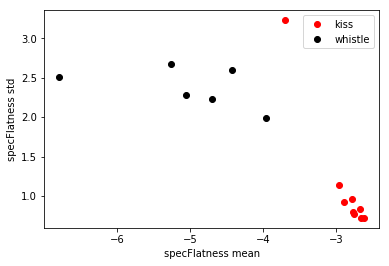

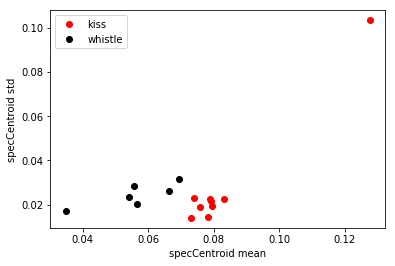

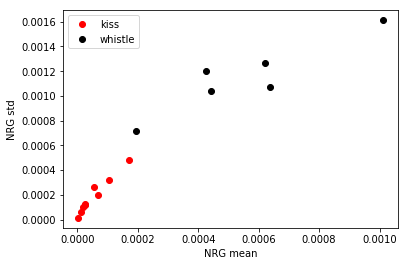

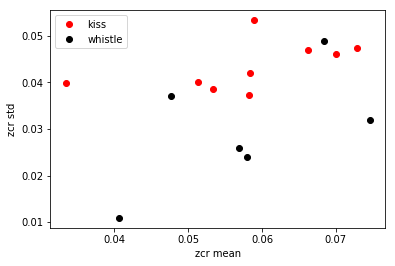

In [4]:
globalFeats=list(globalFeats)
print('List of global features: ',globalFeats)
for feature in ['specFlatness','specCentroid','NRG','zcr']:
    instr1='kiss'
    instr2='whistle'
    plt.plot(globalFeatsData[instr1]['mean_'+feature],globalFeatsData[instr1]['std_'+feature],'ro',label=instr1)
    plt.plot(globalFeatsData[instr2]['mean_'+feature],globalFeatsData[instr2]['std_'+feature],'ko',label=instr2)
    plt.legend(loc='best')
    plt.xlabel(feature+' mean')
    plt.ylabel(feature+' std')
    plt.show()

For similar examples from other course material see: 
1) https://github.com/stevetjoa/stanford-mir/blob/gh-pages/basic_feature_extraction.ipynb , 
2) https://github.com/stevetjoa/stanford-mir/blob/gh-pages/spectral_features.ipynb

### Homework:
Use other queries (musical instrument sounds) to collect small sound datasets from FreeSound and spot statistical features where the classes can be easily separated. Explain why those features are suited for such a task based on acoustic characteristics of the type of sounds available in your dataset.